In [1]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Object detection

Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output
coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects,
each with its own bounding box and a label (e.g. it can have a car and a building), and each object can
be present in different parts of an image (e.g. the image can have several cars).
This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights.
Other applications include counting objects in images, image search, and more.

In this guide, you will learn how to:

 1. Finetune [DETR](https://huggingface.co/docs/transformers/model_doc/detr), a model that combines a convolutional
 backbone with an encoder-decoder Transformer, on the [CPPE-5](https://huggingface.co/datasets/cppe-5)
 dataset.
 2. Use your finetuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[Conditional DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/conditional_detr), [Deformable DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deformable_detr), [DETA](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deta), [DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/detr), [Table Transformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/table-transformer), [YOLOS](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/yolos)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q datasets transformers evaluate timm albumentations
```

You'll use 🤗 Datasets to load a dataset from the Hugging Face Hub, 🤗 Transformers to train your model,
and `albumentations` to augment the data. `timm` is currently required to load a convolutional backbone for the DETR model.

We encourage you to share your model with the community. Log in to your Hugging Face account to upload it to the Hub.
When prompted, enter your token to log in:

## Load the CPPE-5 dataset

The [CPPE-5 dataset](https://huggingface.co/datasets/cppe-5) contains images with
annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

Start by loading the dataset:

In [4]:
from PIL import Image
from collections import defaultdict
import json
import os
from datasets import DatasetDict, Dataset



In [5]:
def coco_to_datasetdict_json(json_path, dataset_type, output_path):
    """
    Transforms COCO data from a JSON file into a newline-delimited JSON file format with a refactored objects structure.
    
    Parameters:
    - json_path: Path to the COCO JSON file.
    - dataset_type: 'train', 'test', or 'validation'
    - output_path: Path to save the newline-delimited JSON file
    
    """
    # Load the COCO data from the given JSON path
    with open(json_path, 'r') as file:
        coco_data = json.load(file)
    
    # Extracting categories
    category_map = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Create a mapping of image id to image info for easier lookup
    image_id_to_info = {img['id']: img for img in coco_data['images']}
    
    # Helper function to convert category name to its corresponding index
    def category_to_index(cat_name):
        return list(category_map.values()).index(cat_name)
    
    # Grouping annotations by image_id for easier processing
    annotations_grouped_by_image_id = defaultdict(list)
    for annotation in coco_data['annotations']:
        annotations_grouped_by_image_id[annotation['image_id']].append(annotation)
    
    # Extract directory from the JSON path to append it to the image paths
    base_directory = os.path.dirname(json_path)
    
    # Open the output file for writing
    with open(output_path, 'w') as out_file:
        # Process and write each entry as a separate line in the output file
        for image_id, annotations in annotations_grouped_by_image_id.items():
            image_info = image_id_to_info[image_id]
            # Appending the base directory to the image path
            image_path = os.path.join(base_directory, image_info['file_name'])
            
            # Refactored structure for objects
            objects = {
                'id': [],
                'area': [],
                'bbox': [],
                'category': []
            }
            
            for annotation in annotations:
                objects['id'].append(annotation['id'])
                objects['area'].append(annotation['area'])
                objects['bbox'].append(annotation['bbox'])
                objects['category'].append(category_to_index(category_map[annotation['category_id']]))
            
            # Create the data entry
            data_entry = {
                'image_id': image_id,
                'image_path': image_path,  # Storing the full path to the image
                'width': image_info['width'],
                'height': image_info['height'],
                'objects': objects
            }
            
            # Write the data entry as a newline-delimited JSON line
            out_file.write(json.dumps(data_entry) + '\n')

# Assuming the paths to the train, test, and validation JSONs
# Note: I will just demonstrate for the provided file, but the same can be applied to other splits.
# Assuming the paths to the train, test, and validation JSONs
train_json_path = "minecraft_coco/train/_annotations.coco.json"
train_json_path_formatted = "minecraft_coco/train/formatted.json"

test_json_path = "minecraft_coco/test/_annotations.coco.json"
test_json_path_formatted = "minecraft_coco/test/formatted.json"

val_json_path = "minecraft_coco/valid/_annotations.coco.json"
val_json_path_formatted = "minecraft_coco/valid/formatted.json"

# Convert and save to newline-delimited JSON
coco_to_datasetdict_json(train_json_path, 'train', train_json_path_formatted)
coco_to_datasetdict_json(test_json_path, 'test', test_json_path_formatted)
coco_to_datasetdict_json(val_json_path, 'valid', val_json_path_formatted)

In [6]:
from datasets import load_dataset

cppe5 = load_dataset('json', data_files={'train': train_json_path_formatted,'test':test_json_path_formatted,'validation':val_json_path_formatted})


Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 305.81it/s]
Generating train split: 2307 examples [00:00, 43286.48 examples/s]
Generating test split: 155 examples [00:00, 29665.39 examples/s]
Generating validation split: 422 examples [00:00, 47125.76 examples/s]


In [7]:
print(cppe5)

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image_path', 'width', 'height', 'objects'],
        num_rows: 2307
    })
    test: Dataset({
        features: ['image_id', 'image_path', 'width', 'height', 'objects'],
        num_rows: 155
    })
    validation: Dataset({
        features: ['image_id', 'image_path', 'width', 'height', 'objects'],
        num_rows: 422
    })
})


In [8]:
cppe5['train'][0]

{'image_id': 0,
 'image_path': 'minecraft_coco/train/2023-03-28_01_53_48_png.rf.003ce2c2d2d84b66b870352b4841cf1d.jpg',
 'width': 854,
 'height': 480,
 'objects': {'id': [0, 1, 2],
  'area': [14152.994, 390.86, 301.192],
  'bbox': [[386.0, 211.0, 101.63, 139.26],
   [498.0, 243.0, 15.01, 26.04],
   [529.0, 242.0, 11.83, 25.46]],
  'category': [10, 17, 17]}}

In [9]:
from PIL import Image
# for image in cppe5['train']:
#    image['image']=Image.open(image['image'])

# for image in cppe5['test']:
#    image['image']=Image.open(image['image'])

# for image in cppe5['validation']:
#    image['image']=Image.open(image['image'])

# print(cppe5['train'][0])
def load_image(example):
    return Image.open(example['image_path'])


cppe5=cppe5.map(lambda example: {'image':load_image(example)})

Map: 100%|██████████| 422/422 [00:00<00:00, 2418.64 examples/s]


In [10]:
print(cppe5['train'][0])

{'image_id': 0, 'image_path': 'minecraft_coco/train/2023-03-28_01_53_48_png.rf.003ce2c2d2d84b66b870352b4841cf1d.jpg', 'width': 854, 'height': 480, 'objects': {'id': [0, 1, 2], 'area': [14152.994, 390.86, 301.192], 'bbox': [[386.0, 211.0, 101.63, 139.26], [498.0, 243.0, 15.01, 26.04], [529.0, 242.0, 11.83, 25.46]], 'category': [10, 17, 17]}, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=854x480 at 0x7FA83A22C790>}


You'll see that this dataset already comes with a training set containing 1000 images and a test set with 29 images.

To get familiar with the data, explore what the examples look like.

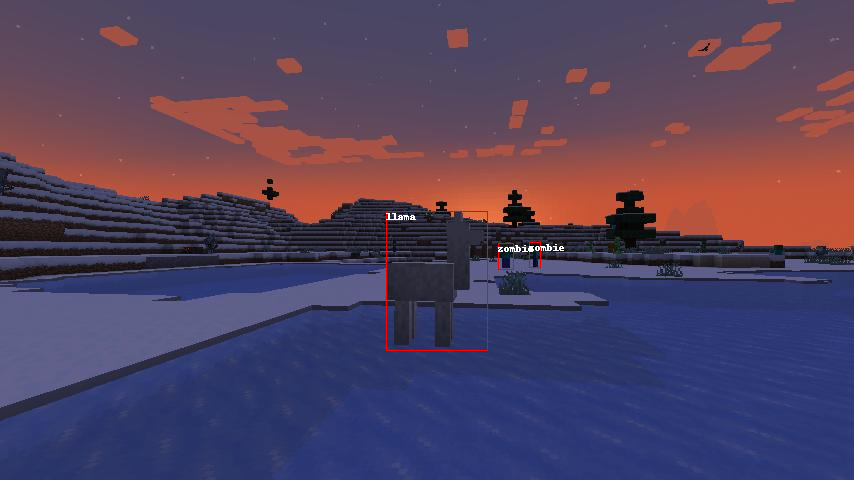

In [12]:
import numpy as np
import os
from PIL import Image, ImageDraw
import json

# Load the provided COCO annotations JSON
with open("minecraft_coco/valid/_annotations.coco.json", "r") as file:
    annotations_data = json.load(file)

# Extract categories information
categories = annotations_data["categories"]

# Create id2label and label2id mappings
id2label = {category["id"]: category["name"] for category in categories}
label2id = {label: id for id, label in id2label.items()}
image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)



# Create a label_to_id dictionary

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

## Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model.
[AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and
`labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial
to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [13]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Before passing the images to the `image_processor`, apply two preprocessing transformations to the dataset:
- Augmenting images
- Reformatting annotations to meet DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/) ...
This library ensures that transformations affect the image and update the bounding boxes accordingly.
The 🤗 Datasets library documentation has a detailed [guide on how to augment images for object detection](https://huggingface.co/docs/datasets/object_detection),
and it uses the exact same dataset as an example. Apply the same approach here, resize each image to (480, 480),
flip it horizontally, and brighten it:

In [14]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

The `image_processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`,
 where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [15]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        print(bbox[i])
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

To ensure bounding boxes stay within the correct range after transformations, you can add a post-processing step to clamp the bounding box values:

In [35]:
def clamp_bbox(bbox):
    x_min, y_min, width, height = bbox
    x_min = max(0.0, x_min)
    y_min = max(0.0, y_min)
    width = min(width, 1.0 - x_min)
    height = min(height, 1.0 - y_min)
    return x_min, y_min, width, height


Now you can combine the image and annotation transformations to use on a batch of examples:

In [52]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])        
        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]
    print(bboxes)

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Apply this preprocessing function to the entire dataset using 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. This method applies
transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor
with `pixel_values`, a tensor with `pixel_mask`, and `labels`.

In [54]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5['train'][0]

(205.92224824355972, 211.0, 57.12224824355971, 139.26)
(191.65714285714284, 243.0, 8.436533957845455, 26.04000000000002)
(176.02060889929743, 242.0, 6.649180327868834, 25.45999999999998)
[[(205.92224824355972, 211.0, 57.12224824355971, 139.26), (191.65714285714284, 243.0, 8.436533957845455, 26.04000000000002), (176.02060889929743, 242.0, 6.649180327868834, 25.45999999999998)]]


{'pixel_values': tensor([[[ 0.2282,  0.2282,  0.2282,  ...,  0.1939,  0.1939,  0.1939],
          [ 0.2282,  0.2282,  0.2282,  ...,  0.1939,  0.1939,  0.1939],
          [ 0.2282,  0.2282,  0.2282,  ...,  0.1939,  0.1939,  0.1939],
          ...,
          [ 0.7077,  0.7077,  0.7077,  ...,  0.3994,  0.3994,  0.3994],
          [ 0.7077,  0.7077,  0.7077,  ...,  0.3994,  0.3994,  0.3994],
          [ 0.7077,  0.7077,  0.7077,  ...,  0.3994,  0.3994,  0.3994]],
 
         [[-0.1099, -0.1099, -0.1099,  ..., -0.1450, -0.1450, -0.1450],
          [-0.1099, -0.1099, -0.1099,  ..., -0.1450, -0.1450, -0.1450],
          [-0.1099, -0.1099, -0.1099,  ..., -0.1450, -0.1450, -0.1450],
          ...,
          [-0.3725, -0.3725, -0.3725,  ..., -0.4776, -0.4776, -0.4776],
          [-0.3725, -0.3725, -0.3725,  ..., -0.4776, -0.4776, -0.4776],
          [-0.3725, -0.3725, -0.3725,  ..., -0.4776, -0.4776, -0.4776]],
 
         [[ 0.3045,  0.3045,  0.3045,  ...,  0.3742,  0.3742,  0.3742],
          [ 

You have successfully augmented the individual images and prepared their annotations. However, preprocessing isn't
complete yet. In the final step, create a custom `collate_fn` to batch images together.
Pad images (which are now `pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask`
to indicate which pixels are real (1) and which are padding (0).

In [45]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training the DETR model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model!
The images in this dataset are still quite large, even after resizing. This means that finetuning this model will
require at least one GPU.

Training involves the following steps:
1. Load the model with [AutoModelForObjectDetection](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
3. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
4. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id`
and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [46]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([19, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([19]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit.
It is important you do not remove unused columns because this will drop the image column. Without the image column, you
can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
If you wish to share your model by pushing to the Hub, set `push_to_hub` to `True` (you must be signed in to Hugging
Face to upload your model).

In [47]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=False,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

Finally, bring everything together, and call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [48]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

trainer.train()

(212.0625, 223.0, 24.9375, 54.0)
(207.08249999999998, 92.44444444444444, 50.41749999999996, 57.035555555555575)
(235.5, 155.33333333333334, 32.8125, 70.66666666666666)
(209.43749999999997, 203.33333333333334, 24.93750000000003, 55.66666666666666)
(223.49999999999997, 180.66666666666666, 12.1875, 16.666666666666657)
(303.03999999999996, 114.66666666666667, 99.96000000000004, 298.8044444444444)
(207.6, 90.66666666666666, 117.9, 201.7733333333334)
(95.13750000000002, 85.33333333333334, 87.86249999999998, 140.43999999999997)
(0.1350000000000584, 110.66666666666667, 110.11499999999997, 149.99999999999994)
(182.45999999999998, 278.6666666666667, 32.79000000000005, 91.95999999999998)
(170.63999999999996, 197.33333333333331, 54.36000000000004, 85.97333333333341)
(234.45807962529275, 176.0, 32.52084309133491, 47.860000000000014)


KeyboardInterrupt: 

## Evaluate

Object detection models are commonly evaluated with a set of <a href="https://cocodataset.org/#detection-eval">COCO-style metrics</a>.
You can use one of the existing metrics implementations, but here you'll use the one from `torchvision` to evaluate the final
model that you pushed to the Hub.

To use the `torchvision` evaluator, you'll need to prepare a ground truth COCO dataset. The API to build a COCO dataset
requires the data to be stored in a certain format, so you'll need to save images and annotations to disk first. Just like
when you prepared your data for training, the annotations from the `cppe5["test"]` need to be formatted. However, images
should stay as they are.

The evaluation step requires a bit of work, but it can be split in three major steps.
First, prepare the `cppe5["test"]` set: format the annotations and save the data to disk.

In [ ]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

Next, prepare an instance of a `CocoDetection` class that can be used with `cocoevaluator`.

In [ ]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(cppe5["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

Finally, load the metrics and run the evaluation.

In [ ]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

These results can be further improved by adjusting the hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). Give it a go!

## Inference

Now that you have finetuned a DETR model, evaluated it, and uploaded it to the Hugging Face Hub, you can use it for inference.
The simplest way to try out your finetuned model for inference is to use it in a [Pipeline](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.Pipeline). Instantiate a pipeline
for object detection with your model, and pass an image to it:

In [ ]:
from transformers import pipeline
import requests

url = "https://i.imgur.com/2lnWoly.jpg"
image = Image.open(requests.get(url, stream=True).raw)

obj_detector = pipeline("object-detection", model="MariaK/detr-resnet-50_finetuned_cppe5")
obj_detector(image)

You can also manually replicate the results of the pipeline if you'd like:

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Let's plot the result:

In [ ]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image